# xcast demo using xarray turtorial datasets

Note: This is mainly to cover the mechanics of using xcast (which is based off of the fantastic scikit-learn pacakge). This is not meant to be an introduction to machine learning methods or best practices.

Uncomment the below line if you have not installed xcast or xarray yet. Installing xarray via pip will require installing some of the dependencies seperatly. See this guide for the xarray here: https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

In [1]:
# conda install -c conda-forge xarray dask netCDF4 bottleneck

# or

# pip install "xarray[complete]"

In [2]:
# conda install -c conda-forge -c hallkjc01 xcast 

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cfgrib
from sklearn.metrics import mean_squared_error

import xcast as xc
from xcast import metric # when we want to score our models
import cartopy.crs as ccrs
import cartopy


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
print('xarray version:', xr.__version__)
print('xcast version:', xc.__version__)

xarray version: 2022.6.0
xcast version: 0.5.7


## Demo dataset from the xarray docs

In [6]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [7]:
# pull out dataarray using dot notation
air_da = ds.air

Made a data array out of the dataset

In [8]:
air_da.shape

(2920, 25, 53)

xcast requires 4 dims, so we will use the epxand_dims fuction

In [9]:
# This will be the entire dataset:
mldataset = air_da.expand_dims({'M': [0]})
mldataset

<xarray.DataArray 'air' (M: 1, time: 2920, lat: 25, lon: 53)>
array([[[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
          238.59999],
         [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
          239.29999],
         [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
          241.7    ],
         ...,
         [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
          294.69998],
         [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
          295.19998],
         [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
          296.6    ]],

        [[242.09999, 242.7    , 243.09999, ..., 232.     , 233.59999,
          235.79999],
         [243.59999, 244.09999, 244.2    , ..., 231.     , 232.5    ,
          235.7    ],
         [253.2    , 252.89   , 252.09999, ..., 230.79999, 233.39   ,
          238.5    ],
...
         [293.69   , 293.88998, 295.38998, ..., 295.09   , 294.69   ,
          294.29   ],
         [296.29   , 297.19   , 297.59   , ..., 295.29   , 295.09   ,
          294.38998],
         [297.79   , 298.38998, 298.49   , ..., 295.69   , 295.49   ,
          295.19   ]],

        [[245.09   , 244.29   , 243.29   , ..., 241.68999, 241.48999,
          241.79   ],
         [249.89   , 249.29   , 248.39   , ..., 239.59   , 240.29   ,
          241.68999],
         [262.99   , 262.19   , 261.38998, ..., 239.89   , 242.59   ,
          246.29   ],
         ...,
         [293.79   , 293.69   , 295.09   , ..., 295.29   , 295.09   ,
          294.69   ],
         [296.09   , 296.88998, 297.19   , ..., 295.69   , 295.69   ,
          295.19   ],
         [297.69   , 298.09   , 298.09   , ..., 296.49   , 296.19   ,
          295.69   ]]]], dtype=float32)
Coordinates:
  * M        (M) int64 0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [10]:
mldataset_test = mldataset.isel(time=slice(-200, None))
mldataset_test

<xarray.DataArray 'air' (M: 1, time: 200, lat: 25, lon: 53)>
array([[[[266.69   , 266.79   , 266.59   , ..., 238.79   , 237.98999,
          237.68999],
         [273.49   , 273.09   , 272.09   , ..., 233.89   , 232.68999,
          233.29   ],
         [271.88998, 270.29   , 268.29   , ..., 237.29   , 237.18999,
          239.48999],
         ...,
         [297.19   , 296.88998, 296.99   , ..., 298.88998, 298.38998,
          297.59   ],
         [298.38998, 298.69   , 298.69   , ..., 299.59   , 299.38998,
          298.59   ],
         [299.29   , 299.49   , 299.29   , ..., 299.88998, 300.09   ,
          299.79   ]],

        [[266.6    , 266.19998, 265.79   , ..., 237.     , 236.79999,
          237.09999],
         [270.29   , 269.6    , 268.79   , ..., 235.09999, 234.18999,
          234.89   ],
         [271.69998, 270.5    , 269.1    , ..., 240.09999, 239.89   ,
          241.79999],
...
         [293.69   , 293.88998, 295.38998, ..., 295.09   , 294.69   ,
          294.29   ],
         [296.29   , 297.19   , 297.59   , ..., 295.29   , 295.09   ,
          294.38998],
         [297.79   , 298.38998, 298.49   , ..., 295.69   , 295.49   ,
          295.19   ]],

        [[245.09   , 244.29   , 243.29   , ..., 241.68999, 241.48999,
          241.79   ],
         [249.89   , 249.29   , 248.39   , ..., 239.59   , 240.29   ,
          241.68999],
         [262.99   , 262.19   , 261.38998, ..., 239.89   , 242.59   ,
          246.29   ],
         ...,
         [293.79   , 293.69   , 295.09   , ..., 295.29   , 295.09   ,
          294.69   ],
         [296.09   , 296.88998, 297.19   , ..., 295.69   , 295.69   ,
          295.19   ],
         [297.69   , 298.09   , 298.09   , ..., 296.49   , 296.19   ,
          295.69   ]]]], dtype=float32)
Coordinates:
  * M        (M) int64 0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2014-11-12 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

Let's keep mldataset_test seperate for a while.

In [11]:
mldataset_train = mldataset.isel(time=slice(0, -200))
mldataset_train

<xarray.DataArray 'air' (M: 1, time: 2720, lat: 25, lon: 53)>
array([[[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
          238.59999],
         [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
          239.29999],
         [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
          241.7    ],
         ...,
         [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
          294.69998],
         [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
          295.19998],
         [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
          296.6    ]],

        [[242.09999, 242.7    , 243.09999, ..., 232.     , 233.59999,
          235.79999],
         [243.59999, 244.09999, 244.2    , ..., 231.     , 232.5    ,
          235.7    ],
         [253.2    , 252.89   , 252.09999, ..., 230.79999, 233.39   ,
          238.5    ],
...
         [296.49   , 295.88998, 296.49   , ..., 298.69   , 298.09   ,
          297.38998],
         [297.19   , 297.79   , 298.38998, ..., 298.88998, 298.79   ,
          298.49   ],
         [298.49   , 299.09   , 299.09   , ..., 299.59   , 299.59   ,
          299.59   ]],

        [[263.19   , 263.29   , 263.38998, ..., 238.09   , 236.89   ,
          236.18999],
         [271.99   , 272.29   , 272.29   , ..., 232.29   , 231.39   ,
          232.18999],
         [271.79   , 270.88998, 269.99   , ..., 235.59   , 235.89   ,
          238.39   ],
         ...,
         [297.19   , 296.49   , 296.29   , ..., 298.79   , 298.59   ,
          297.88998],
         [298.09   , 298.49   , 298.38998, ..., 299.49   , 299.59   ,
          298.99   ],
         [298.88998, 299.38998, 299.38998, ..., 300.19   , 299.99   ,
          299.88998]]]], dtype=float32)
Coordinates:
  * M        (M) int64 0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-11-11T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

OK, now we have the training dataset, but we want to look 2 time steps ahead. For xcast, the x and y (not lat and long!) need to be the same size for timesteps.

In [12]:
how_many_steps = 5

mltrainX = mldataset_train.isel(time=slice(0,-1*how_many_steps)) # from the start to 2 from the end
mltrainY = mldataset_train.isel(time=slice(how_many_steps,None)) # 2 from the start to the end


Sanity check:

In [13]:
mltrainX.shape == mltrainY.shape

True

Just testing if I can train a model. I seem to have lost the plot somewhere.

In [14]:
mltrainX

<xarray.DataArray 'air' (M: 1, time: 2715, lat: 25, lon: 53)>
array([[[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
          238.59999],
         [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
          239.29999],
         [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
          241.7    ],
         ...,
         [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
          294.69998],
         [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
          295.19998],
         [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
          296.6    ]],

        [[242.09999, 242.7    , 243.09999, ..., 232.     , 233.59999,
          235.79999],
         [243.59999, 244.09999, 244.2    , ..., 231.     , 232.5    ,
          235.7    ],
         [253.2    , 252.89   , 252.09999, ..., 230.79999, 233.39   ,
          238.5    ],
...
         [298.     , 297.5    , 297.19998, ..., 298.79   , 298.29   ,
          297.79   ],
         [298.6    , 299.     , 298.69998, ..., 299.     , 298.88998,
          298.69998],
         [299.     , 299.6    , 299.38998, ..., 299.5    , 299.29   ,
          299.38998]],

        [[254.59   , 253.79   , 253.48999, ..., 240.68999, 240.39   ,
          240.29   ],
         [259.79   , 257.69   , 255.98999, ..., 237.09   , 236.89   ,
          238.09   ],
         [271.19   , 269.49   , 267.79   , ..., 234.39   , 236.98999,
          241.68999],
         ...,
         [296.79   , 296.19   , 296.09   , ..., 299.49   , 298.49   ,
          297.88998],
         [297.59   , 298.29   , 298.09   , ..., 299.49   , 299.38998,
          298.99   ],
         [298.59   , 299.29   , 298.88998, ..., 300.09   , 299.99   ,
          299.99   ]]]], dtype=float32)
Coordinates:
  * M        (M) int64 0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-11-10T12:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [15]:
rf = xc.rRandomForest() 

rf.fit(mltrainX, mltrainY)

Let's see how it does on the training data:

In [16]:
mltestX = mldataset_test.isel(time=slice(0,-1*how_many_steps)) # from the start to how_many_steps from the end
mltestY = mldataset_test.isel(time=slice(how_many_steps,None)) # how_many_steps from the start to the end

In [17]:
preds = rf.predict(mltestX)

Using xcast, you can define your own metrics too

In [18]:
@metric
def MeanSquaredError(X, Y):
    return mean_squared_error(X, Y)

In [19]:
mse = MeanSquaredError(preds.mean('ND'), mltestY, x_sample_dim='time', x_feature_dim='M', y_feature_dim='M', y_sample_dim='time')

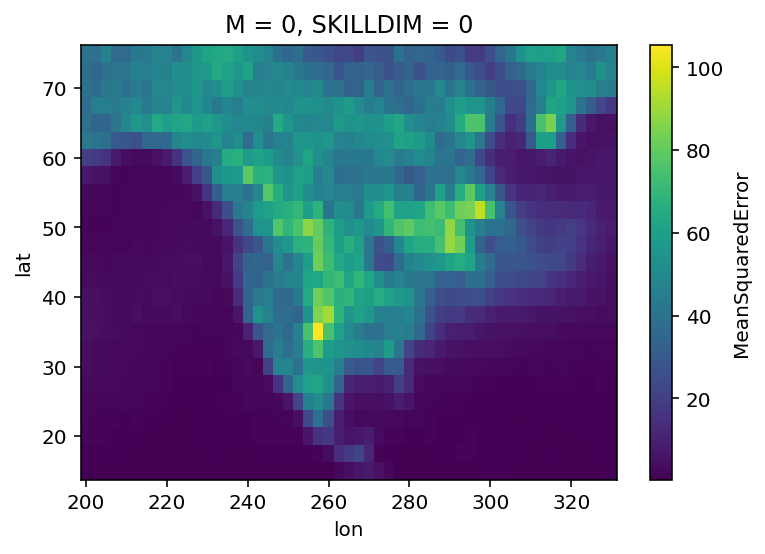

In [20]:
mse.plot()

# Grib Example w/Cartopy

xarray example doc's has a GRIB file format example. We will use that dataset re-use and the code examples.

Full turtorial is here: https://docs.xarray.dev/en/v2022.06.0/examples/ERA5-GRIB-example.html

In [21]:
dsG = xr.tutorial.load_dataset("era5-2mt-2019-03-uk.grib", engine="cfgrib") #note the engine when loading GRIB files

If you get an error loading in this dataset, 9 times out of 10 its loading/debugging the cfGRIB package. Xarray has many different data loading engines, everything downstream of this should be the same if it is a Lat, Lon, time, feature type of dataset.

Other data loading engines are: ({"netcdf4", "scipy", "pydap", "h5netcdf", "pynio", "cfgrib", "pseudonetcdf", "zarr", None}

In [22]:
dsG

<xarray.Dataset>
Dimensions:     (time: 744, latitude: 33, longitude: 49)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2019-03-01 ... 2019-03-31T23:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 58.0 57.75 57.5 57.25 ... 50.5 50.25 50.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 1.25 1.5 1.75 2.0
    valid_time  (time) datetime64[ns] 2019-03-01 ... 2019-03-31T23:00:00
Data variables:
    t2m         (time, latitude, longitude) float32 282.4 282.3 ... 281.5 281.5
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-08-22T14:11 GRIB to CDM+CF via cfgrib-0.9.1...

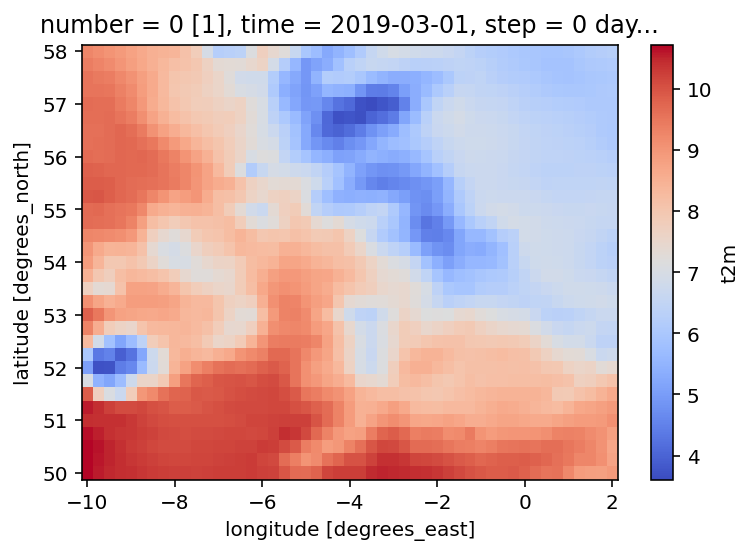

In [23]:
dsG = dsG - 273.15
dsG.t2m[0].plot(cmap=plt.cm.coolwarm)

Text(0.5, 1.0, 'ERA5 - 2m temperature British Isles March 2019')

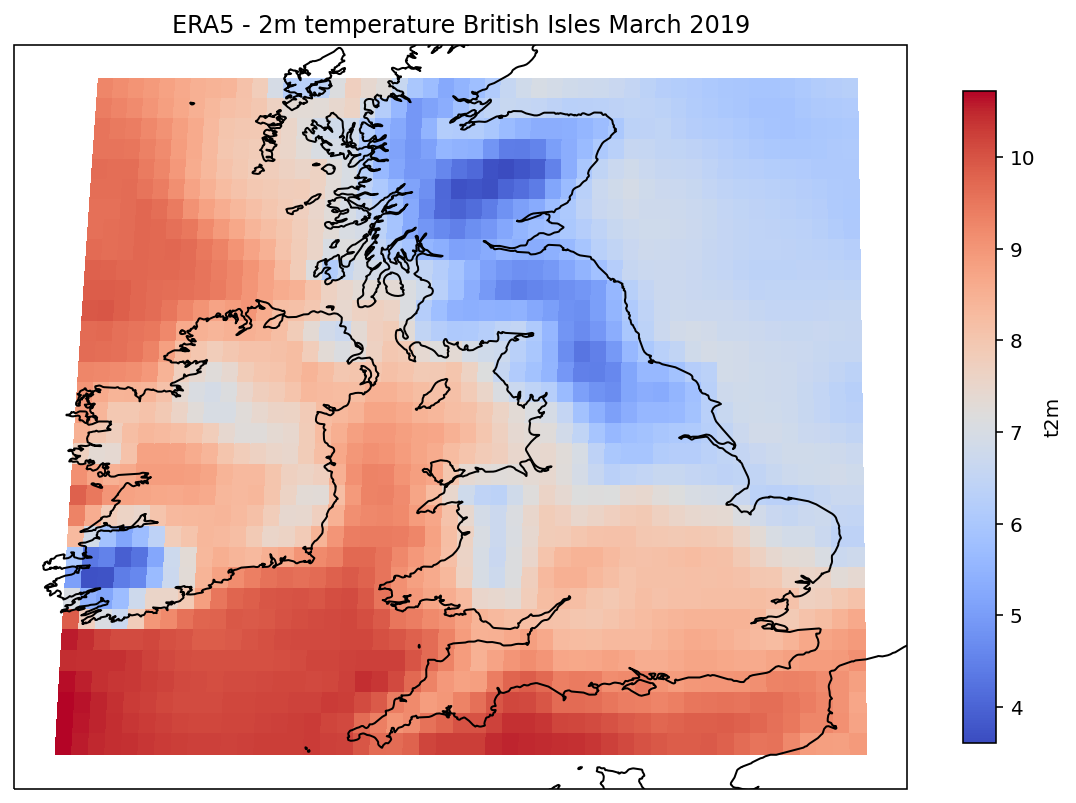

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())

plot = dsG.t2m[0].plot(
    cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6}
)

ax.coastlines(resolution="10m") # changed the order to put the coastline ontop of the image
plt.title("ERA5 - 2m temperature British Isles March 2019")

If we want to split out a single timeseries from a specific lat/long:

Text(0.5, 1.0, 'ERA5 - London 2m temperature March 2019')

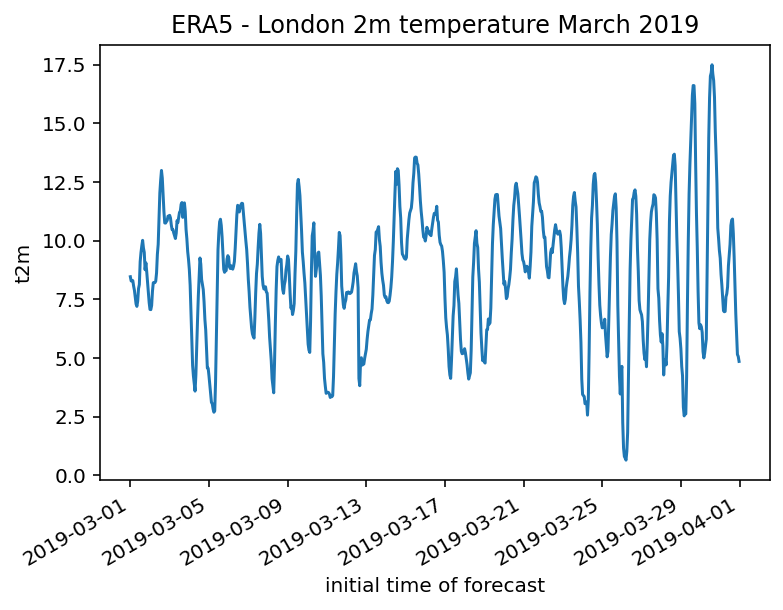

In [25]:
dsG.t2m.sel(longitude=0, latitude=51.5).plot()
plt.title("ERA5 - London 2m temperature March 2019")

### Can do time series ML, identical to the above netCDF example:

In [26]:
uk_temp = dsG.t2m #xcast wants data arrays, not datasets
uk_data = uk_temp.expand_dims({'M': [0]}) # xcast expects a 4th dimm

In [27]:
uk_train = uk_data.isel(time=slice(0, -20))
uk_test = uk_data.isel(time=slice(-20, None)) # pulling the last 20 time steps of the data

print('training dataset shape:', uk_train.shape)
print('testing dataset shape:', uk_test.shape)

training dataset shape: (1, 724, 33, 49)
testing dataset shape: (1, 20, 33, 49)


Note the 4 dimmensions, and the same X and Y dimmension sizes

In [28]:
uk_step_size = 2 # how many time steps we want to look in the future

In [29]:
uk_trainX = uk_train.isel(time=slice(0,-1*uk_step_size)) # from the start to how_many_steps from the end
uk_trainY = uk_train.isel(time=slice(uk_step_size,None)) # how_many_steps from the start to the end

In [30]:
mlr = xc.rMultipleLinearRegression() #xcast has a few different options for estimators

mlr.fit(uk_trainX, uk_trainY)

In [31]:
uk_testX = uk_test.isel(time=slice(0,-1*uk_step_size)) # from the start to how_many_steps from the end
uk_testY = uk_test.isel(time=slice(uk_step_size,None)) # how_many_steps from the start to the end

In [32]:
ukpreds = mlr.predict(uk_testX)

In [33]:
@metric
def Pearson(predicted, observed):
	"""abstracts out coefficient from stats.pearsonr"""
	if np.isnan(np.min(predicted)) or np.isnan(np.min(observed)):
		return np.asarray([np.nan])
	coef, p = stats.pearsonr(np.squeeze(predicted).astype(float), np.squeeze(observed).astype(float))
	return coef

In [34]:
results = Pearson(ukpreds.mean('ND'), uk_testY, x_sample_dim='time', x_feature_dim='M', y_feature_dim='M', y_sample_dim='time')

Text(0.5, 1.0, 'Pearson Results')

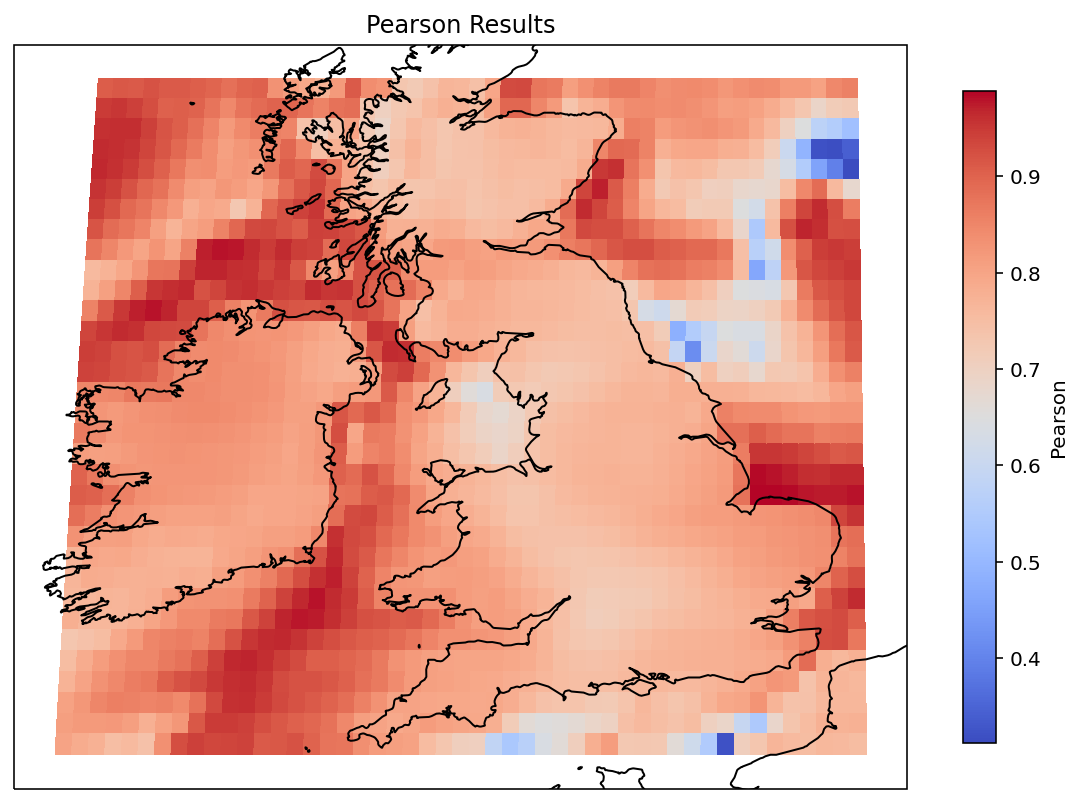

In [35]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())

plot = results.plot(
    cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6}
)

ax.coastlines(resolution="10m") # changed the order to put the coastline ontop of the image
plt.title('Pearson Results')
